### Credenciais de Acesso Kaggle

In [1]:
{"username":"jcss03","key":"caf02cc87bdafff295f9eb6897072757"}

{'username': 'jcss03', 'key': 'caf02cc87bdafff295f9eb6897072757'}

### Imports

In [2]:
!pip install opendatasets
!pip install pandas

import opendatasets as od
import pandas
# utilities
import re
import numpy as np
import pandas as pd
# plotting
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt
# nltk
from nltk.stem import WordNetLemmatizer
# sklearn
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report

import string
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer

import re

from sklearn import feature_extraction, model_selection, naive_bayes, pipeline, manifold, preprocessing


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


### Download Dataset

In [3]:

# download data from kaggle
od.download("https://www.kaggle.com/datasets/jp797498e/twitter-entity-sentiment-analysis/download?datasetVersionNumber=2")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: jcss03
Your Kaggle Key: ··········


100%|██████████| 1.99M/1.99M [00:00<00:00, 115MB/s]

In [4]:
# caminho para o dataset
!ls ./twitter-entity-sentiment-analysis

twitter_training.csv  twitter_validation.csv


### Acesso ao Drive

In [5]:
# Acesso a pasta do drive
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [6]:
# exemplo
!ls /content/drive/MyDrive/'Trabalho de Graduação'/scripts

 data			      projectRoadmap
 Exploratory_Analysis.ipynb  'scripts testes'
 model			      solve_overfitting_model_BoW_tf_idf.ipynb
 overfitting_model.ipynb


### Loading Datasets
* Train
* Test

In [7]:
dataset_train = pd.read_csv('./twitter-entity-sentiment-analysis/twitter_training.csv',names=['Tweet_ID','entity','sentiment','Tweet content'],header=None)
dataset_validation = pd.read_csv('./twitter-entity-sentiment-analysis/twitter_validation.csv',names=['Tweet_ID','entity','sentiment','Tweet content'],header=None)

In [8]:
print('Exemplo do dataset')
dataset_train.sample(5)

Exemplo do dataset


,Tweet_ID,entity,sentiment,Tweet content
62159,5055,GrandTheftAuto(GTA),Neutral,"If I ever learn how properly code/model, I wan..."
56464,11289,TomClancysRainbowSix,Negative,I ’ m just done with all @Rainbow6Game unless ...
34750,6768,Fortnite,Negative,org RhandlerR what a great game! went into cre...
26532,958,AssassinsCreed,Irrelevant,Follow my favorite YouTuber JorRaptor!
53535,10800,RedDeadRedemption(RDR),Positive,Treated dad to a PS4 a few months ago after no...


#### Encodificar Targets

In [9]:
data = dataset_train[['Tweet content','sentiment']].rename(columns={"Tweet content": "text", "sentiment": "target"})
data.target = pd.Categorical(data.target)

data['code'] = data.target.cat.codes
print('#'*100)
print(f'Targets: {data.target.unique()}')
print(f'Codes: {data.code.unique()}')
print('#'*100)
data.sample(5)

####################################################################################################
Targets: ['Positive', 'Neutral', 'Negative', 'Irrelevant']
Categories (4, object): ['Irrelevant', 'Negative', 'Neutral', 'Positive']
Codes: [3 2 1 0]
####################################################################################################


,text,target,code
3690,It’s official I’m hyped .,Positive,3
62953,GTA Online Best Vehicle Discounts (September 1...,Neutral,2
31763,of,Neutral,2
16050,"Too many people play dota 2, and internet goes...",Positive,3
41508,A ban for Battlefield 4 player Chiiroolaa has ...,Irrelevant,0


#### Remover valores Null

In [10]:
print('#'*100)
qtd_null_values = np.sum(data.isnull().any(axis=1))
print(f'Shape dos dados: {data.shape}')
print(f'Number null values = {qtd_null_values}')

# dropna values
data = data.dropna().reset_index(drop=True)

print('#'*100)
qtd_null_values = np.sum(data.isnull().any(axis=1))
print(f'Shape dos dados: {data.shape}')
print(f'Number null values = {qtd_null_values}')

####################################################################################################
Shape dos dados: (74682, 3)
Number null values = 686
####################################################################################################
Shape dos dados: (73996, 3)
Number null values = 0


### Processing Text
* stopwords
* punctuation
* Stemming(reducing the words to their derived stems)
* Lemmatization(reducing the derived words to their root form known as lemma)
* removing unnecessary characters
* lower case text to better generalization

In [11]:
# recebe texto e processa
def processing_text(text,flag_punctuation=False,flag_stopwords=False,flag_stem=False,flag_lemma=False):

  ##############################################################################
  # funções

  # maketrans explained - 'https://www.w3schools.com/python/ref_string_maketrans.asp'
  def cleaning_punctuations(text):
      english_punctuations = string.punctuation
      punctuations_list = english_punctuations

      translator = str.maketrans('', '', punctuations_list)
      return text.translate(translator)
  
  # remover stopwords
  def remove_stopwords(text):
    stop_words = set(stopwords.words('english'))
    text = " ".join([word for word in text.split(' ') if word not in stop_words])
    return text

  # removendo chars repetidos
  def cleaning_repeating_char(text):
      return re.sub(r'(.)1+', r'1', text)

  # removing stem
  def stemming(text):
    ps = PorterStemmer()
    text = " ".join([ps.stem(word) for word in text.split(' ')])
    return text

  def lemmatizer(text):
      lm = nltk.WordNetLemmatizer()
      text = " ".join([lm.lemmatize(word) for word in text.split(' ')])
      return text
  ##############################################################################

  # Processing

  # lower all string of text
  text = re.sub(r'[^\w\s]', '', str(text).lower().strip())

  # remover pontuações
  if flag_punctuation:
    text = cleaning_punctuations(text)

  # remover stopwords
  if flag_stopwords:
    text = remove_stopwords(text)

  # remover repetições
  text = cleaning_repeating_char(text)

  # lenma
  if flag_lemma:
    text = lemmatizer(text)

  # stem:
  if flag_stem:
    text = stemming(text)

  return text

In [12]:
example = data.text.iloc[100]
example

'Grounded almost was pretty cool even despite the top tier unfunny writing until we became yet another annoying crafting game. I seriously can’t wait on this shitty trend to die'

In [13]:
clean_text = processing_text(example,flag_punctuation=True,flag_stopwords=True,flag_lemma=True)
clean_text

'grounded almost pretty cool even despite top tier unfunny writing became yet another annoying crafting game seriously cant wait shitty trend die'

In [14]:
# clean text
data['clean_text'] = data['text'].apply(lambda x: processing_text(x,flag_punctuation=True,flag_stopwords=True,flag_lemma=True))

In [15]:
data.sample(10)

,text,target,code,clean_text
60060,Fight. @ ajpencia083 @ Gonzalez _ 02 _,Irrelevant,0,fight ajpencia083 gonzalez 02
54864,My bad @ CfDuty I didn't fix it thanks to you ...,Neutral,2,bad cfduty didnt fix thanks good far
62529,see RhandlerR lmao i think there’s something w...,Negative,1,see rhandlerr lmao think there something wrong...
62765,@EAMaddenNFL and @EASPORTSNHL should take a pa...,Negative,1,eamaddennfl easportsnhl take page need easport...
12470,Aye why @NBA2K_MyTEAM give @mikal_bridges this...,Negative,1,aye nba2kmyteam give mikalbridges fye as card ...
30292,Super happy to work with @WIHSesports to make ...,Irrelevant,0,super happy work wihsesports make opportunity ...
59521,removed my sister from Facebook too no one is ...,Negative,1,removed sister facebook one safe racist x
7042,I can't get overwatch out of my head. I wanna ...,Positive,3,cant get overwatch head wanna grind thhat game...
1140,"I'm honestly not sure how I feel about this, I...",Positive,3,im honestly sure feel im going see thing shape...
42349,When... Then.,Neutral,2,


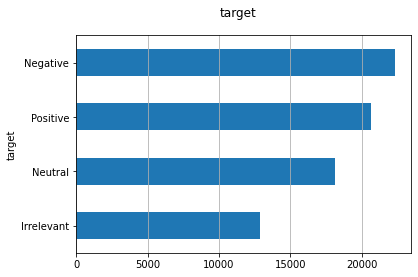

In [16]:
fig, ax = plt.subplots()
fig.suptitle("target", fontsize=12)
data["target"].reset_index().groupby("target").count().sort_values(by= 
       "index").plot(kind="barh", legend=False, 
        ax=ax).grid(axis='x')
plt.show()

In [ ]:
# data = data[data.target != 'Irrelevant']


In [18]:
print(data.target.unique())
print(data.code.unique())


['Positive', 'Neutral', 'Negative', 'Irrelevant']
Categories (4, object): ['Irrelevant', 'Negative', 'Neutral', 'Positive']
[3 2 1 0]


### Split dataset_train 
* train
* validation

In [19]:
from sklearn.model_selection import train_test_split

# split dataset
df_train, df_val = train_test_split(data[['code','clean_text']], test_size=0.3)
## get target
target_train = df_train["code"].values
target_val = df_val["code"].values

### Bag of Words
* classic
* tf-idf

In [ ]:
# # ## Count (classic BoW)
# # vectorizer = feature_extraction.text.CountVectorizer(max_features=15000, ngram_range=(1,2))

# ## Tf-Idf (advanced variant of BoW)
# vectorizer = feature_extraction.text.TfidfVectorizer(max_features=25000, ngram_range=(1,2))

In [ ]:
# corpus = df_train["clean_text"]

# vectorizer.fit(corpus)
# X_train = vectorizer.transform(corpus)
# dic_vocabulary = vectorizer.vocabulary_

In [ ]:
# sns.heatmap(X_train.todense()[:,np.random.randint(0,X_train.shape[1],100)]==0, vmin=0, vmax=1, cbar=False).set_title('Sparse Matrix Sample')

### Classifier MultinimialNB

In [ ]:
# ok

In [ ]:
# classifier = naive_bayes.MultinomialNB()

# ## pipeline
# model = pipeline.Pipeline([("vectorizer", vectorizer),  
#                            ("classifier", classifier)])
# ## train classifier
# model["classifier"].fit(X_train, target_train)
# ## test
# X_val = df_val["clean_text"].values

# predicted = model.predict(X_val)
# predicted_prob = model.predict_proba(X_val)

In [ ]:
# ## Accuracy, Precision, Recall
# from sklearn import metrics
# accuracy = metrics.accuracy_score(target_val, predicted)
# auc = metrics.roc_auc_score(target_val, predicted_prob, 
#                             multi_class="ovr")
# print("Accuracy:",  round(accuracy,2))a
# print("Auc:", round(auc,2))
# print("Detail:")
# print(metrics.classification_report(target_val, predicted))
 

In [ ]:
# ## Plot confusion matrix
# classes = np.unique(target_val)
# cm = metrics.confusion_matrix(target_val, predicted)
# fig, ax = plt.subplots()
# sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
#             cbar=False)
# ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
#        yticklabels=classes, title="Confusion matrix")
# plt.yticks(rotation=0)

### Deep Learning

In [20]:
features_train = df_train["clean_text"]
features_val = df_val['clean_text']

target_train = df_train["code"].values
target_val = df_val["code"].values

In [21]:
# df_train[df_train['clean_text'].str.len() == df_train['clean_text'].str.len().max()]

# vocab_size = 100000 # make the top list of words (common words)
# embedding_dim = 64
# max_length = 200
max_length = int(data['clean_text'].str.len().max())
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>' # OOV = Out of Vocabulary



In [22]:
import tensorflow as tf
import tensorflow.keras as keras

import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, LSTM, Dropout, Activation, Embedding, Bidirectional



In [23]:
train_text = df_train['clean_text']

tokenizer = Tokenizer(oov_token=oov_tok)
tokenizer.fit_on_texts(train_text)
word_index = tokenizer.word_index

train_sequences = tokenizer.texts_to_sequences(train_text)
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

val_sequences = tokenizer.texts_to_sequences(df_val['clean_text'])
val_padded = pad_sequences(val_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

### Input

In [24]:
print('Train padded',train_padded.shape)
print('Val padded',val_padded.shape)

print('Train labels',target_train.shape)
print('Val labels',target_val.shape)


Train padded (51797, 810)
Val padded (22199, 810)
Train labels (51797,)
Val labels (22199,)


In [25]:
inputs_train = train_padded.reshape(train_padded.shape[0],train_padded.shape[1],1)

inputs_val = val_padded.reshape(val_padded.shape[0],val_padded.shape[1],1)

print('Train padded',inputs_train.shape)
print('Val padded',inputs_val.shape)

Train padded (51797, 810, 1)
Val padded (22199, 810, 1)


In [26]:
input_shape = (inputs_train.shape[1],inputs_train.shape[2])

In [27]:
n_classes = data.code.nunique()
print(n_classes)

4


In [28]:
words_count = len(word_index) + 1
n_dim = 128

model = keras.Sequential()

model.add(Embedding(words_count,n_dim,input_length = (inputs_train.shape[1])))
model.add(keras.layers.BatchNormalization())

model.add(keras.layers.Bidirectional(tf.compat.v1.keras.layers.CuDNNLSTM(256)))
model.add(keras.layers.Dropout(0.3))

model.add(Dense(128,activation='relu'))
model.add(keras.layers.Dropout(0.3))

model.add(Dense(n_classes,activation='softmax'))

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 810, 128)          4538880   
                                                                 
 batch_normalization (BatchN  (None, 810, 128)         512       
 ormalization)                                                   
                                                                 
 bidirectional (Bidirectiona  (None, 512)              790528    
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 128)               65664     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0

In [ ]:
# model = keras.Sequential()

# # model.add(tf.compat.v1.keras.layers.CuDNNLSTM(128, input_shape=input_shape,return_sequences=True))
# model.add(keras.layers.Bidirectional(tf.compat.v1.keras.layers.CuDNNLSTM(128,return_sequences=True),input_shape=input_shape))

# model.add(keras.layers.Dropout(0.3))
# # model.add(keras.layers.LSTM(128, input_shape=input_shape,return_sequences=True))

# # model.add(keras.layers.BatchNormalization())
# # model.add(keras.layers.MaxPooling1D())

# model.add(keras.layers.Bidirectional(tf.compat.v1.keras.layers.CuDNNLSTM(64)))
# # model.add(keras.layers.LSTM(64))
# model.add(keras.layers.Dropout(0.3))

# model.add(keras.layers.Dense(32, activation='relu'))
# model.add(keras.layers.Dropout(0.3))

# model.add(keras.layers.Dense(4,activation='softmax'))
# # model.add(keras.layers.Dense(1,activation='sigmoid'))


# model.summary()

In [29]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [30]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
GPU_NAME = tf.test.gpu_device_name()
print(GPU_NAME)

Num GPUs Available:  1
/device:GPU:0


In [31]:
with tf.device(GPU_NAME):
  epochs = 50
  batch_size = 128
  history = model.fit(inputs_train,target_train,validation_data=(inputs_val,target_val),batch_size=batch_size, epochs=epochs, verbose=1)

Epoch 1/50
405/405 [==============================] - 106s 240ms/step - loss: 0.8622 - accuracy: 0.6511 - val_loss: 0.7349 - val_accuracy: 0.7580
Epoch 2/50
405/405 [==============================] - 101s 249ms/step - loss: 0.3567 - accuracy: 0.8698 - val_loss: 0.4003 - val_accuracy: 0.8541
Epoch 3/50
405/405 [==============================] - 103s 255ms/step - loss: 0.1935 - accuracy: 0.9261 - val_loss: 0.4069 - val_accuracy: 0.8683
Epoch 4/50
405/405 [==============================] - 104s 256ms/step - loss: 0.1420 - accuracy: 0.9438 - val_loss: 0.4938 - val_accuracy: 0.8645
Epoch 5/50
405/405 [==============================] - 104s 256ms/step - loss: 0.1177 - accuracy: 0.9527 - val_loss: 0.5138 - val_accuracy: 0.8719
Epoch 6/50
405/405 [==============================] - 103s 253ms/step - loss: 0.1054 - accuracy: 0.9566 - val_loss: 0.5434 - val_accuracy: 0.8748
Epoch 7/50
405/405 [==============================] - 102s 253ms/step - loss: 0.0953 - accuracy: 0.9593 - val_loss: 0.5638 -

### Graficos

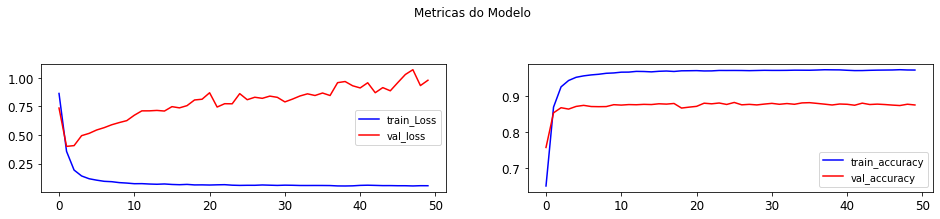

In [32]:
import matplotlib as m
m.rcParams['axes.labelsize'] = 14
m.rcParams['xtick.labelsize'] = 12
m.rcParams['ytick.labelsize'] = 12
m.rcParams['text.color'] = 'k'
from matplotlib.pylab import rcParams 
rcParams['figure.figsize'] = 16,8


plt.suptitle('Metricas do Modelo')

plt.subplot(3,2,1)
plt.plot(history.history['loss'],label='train_Loss',color = 'Blue')
plt.plot(history.history['val_loss'],label='val_loss',color = 'red')
plt.legend(loc='best')

plt.subplot(3,2,2)
plt.plot(history.history['accuracy'],label='train_accuracy',color = 'Blue')
plt.plot(history.history['val_accuracy'],label='val_accuracy',color = 'red')
plt.legend(loc='best')

plt.show()

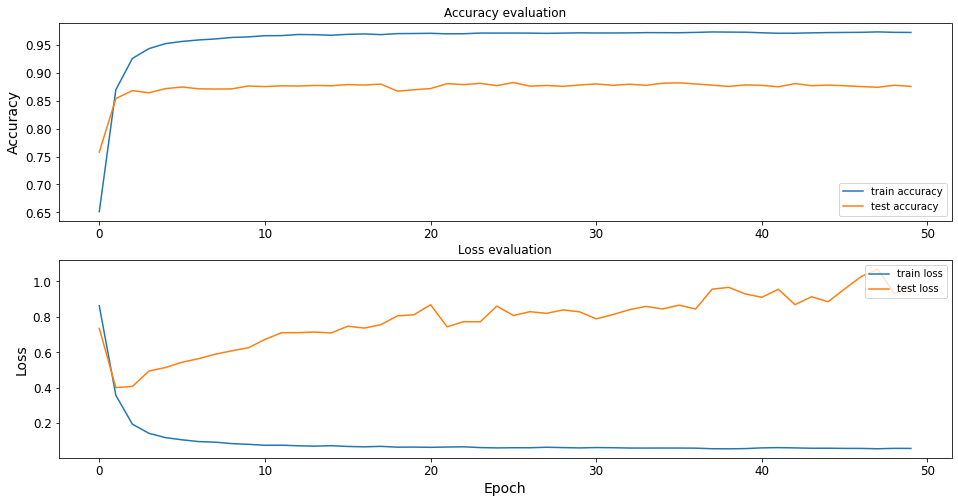

In [33]:
def plot_history(history):
    """Plots accuracy/loss for training/validation set as a function of the epochs
        :param history: Training history of model
        :return:
    """

    fig, axs = plt.subplots(2)

    # create accuracy sublpot
    axs[0].plot(history.history["accuracy"], label="train accuracy")
    axs[0].plot(history.history["val_accuracy"], label="test accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy evaluation")

    # create error sublpot
    axs[1].plot(history.history["loss"], label="train loss")
    axs[1].plot(history.history["val_loss"], label="test loss")
    axs[1].set_ylabel("Loss")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Loss evaluation")

    plt.show()

plot_history(history)

### Test data Classification

In [34]:
print(f'Targets: {data.target.unique()}')
print(f'Codes: {data.code.unique()}')
labels = dict(zip(data.target.unique(),data.code.unique()))

Targets: ['Positive', 'Neutral', 'Negative', 'Irrelevant']
Categories (4, object): ['Irrelevant', 'Negative', 'Neutral', 'Positive']
Codes: [3 2 1 0]


In [35]:
labels

{'Positive': 3, 'Neutral': 2, 'Negative': 1, 'Irrelevant': 0}

In [36]:
dataset_validation.columns

Index(['Tweet_ID', 'entity', 'sentiment', 'Tweet content'], dtype='object')

In [37]:
# encode labels
dataset_validation['code'] = dataset_validation['sentiment'].apply(lambda x: labels[x])
# processing text
dataset_validation['clean_text'] = dataset_validation['Tweet content'].apply(lambda x: processing_text(x,flag_punctuation=True,flag_stopwords=True,flag_lemma=True))

In [38]:
test_sequences = tokenizer.texts_to_sequences(dataset_validation['clean_text'])
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
inputs_test = test_padded.reshape(test_padded.shape[0],test_padded.shape[1],1)

In [40]:
print(type(inputs_test), inputs_test.shape)
targets_teste = np.array(dataset_validation['code'].to_list())
print(type(targets_teste), targets_teste.shape)

<class 'numpy.ndarray'> (1000, 810, 1)
<class 'numpy.ndarray'> (1000,)


### Evaluation 
* teste set
* train set
* val set

In [41]:
accr = model.evaluate(inputs_test,targets_teste)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

32/32 [==============================] - 3s 65ms/step - loss: 0.5376 - accuracy: 0.9440
Test set
  Loss: 0.538
  Accuracy: 0.944


In [42]:
accr_train = model.evaluate(inputs_train,target_train)
print('Train set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr_train[0],accr_train[1]))

1619/1619 [==============================] - 57s 35ms/step - loss: 0.0516 - accuracy: 0.9750
Train set
  Loss: 0.052
  Accuracy: 0.975


In [43]:
accr_val = model.evaluate(inputs_val,target_val)
print('Val set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr_val[0],accr_val[1]))

694/694 [==============================] - 24s 35ms/step - loss: 0.9775 - accuracy: 0.8759
Val set
  Loss: 0.978
  Accuracy: 0.876


### Other Metrics

In [44]:
from sklearn.metrics import classification_report

In [45]:
predictions_test = model.predict(inputs_test)
print('Classification Report Test',classification_report(targets_teste, predictions_test.argmax(axis=1)))

Classification Report Test               precision    recall  f1-score   support

           0       0.95      0.93      0.94       172
           1       0.97      0.96      0.96       266
           2       0.96      0.92      0.94       285
           3       0.91      0.96      0.93       277

    accuracy                           0.94      1000
   macro avg       0.95      0.94      0.94      1000
weighted avg       0.94      0.94      0.94      1000



In [46]:
predictions_train = model.predict(inputs_train)
print('Classification Report Train',classification_report(target_train, predictions_train.argmax(axis=1)))

Classification Report Train               precision    recall  f1-score   support

           0       1.00      0.96      0.98      8997
           1       0.98      0.97      0.98     15675
           2       1.00      0.96      0.98     12642
           3       0.94      0.99      0.96     14483

    accuracy                           0.97     51797
   macro avg       0.98      0.97      0.98     51797
weighted avg       0.98      0.97      0.98     51797



In [47]:
predictions_val = model.predict(inputs_val)
print('Classification Report Val',classification_report(target_val, predictions_val.argmax(axis=1)))

Classification Report Val               precision    recall  f1-score   support

           0       0.88      0.85      0.86      3878
           1       0.89      0.90      0.89      6683
           2       0.90      0.84      0.87      5466
           3       0.84      0.90      0.87      6172

    accuracy                           0.88     22199
   macro avg       0.88      0.87      0.87     22199
weighted avg       0.88      0.88      0.88     22199

